# Brain Tumor MRI Classification

#  AlexNet-KNN Hybrid
### Author: Ethan Gilles

---

## Importing libraries

In [2]:
import os
import sys
import math
import random
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

## Setup cuda drivers

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

## Data loading

In [ ]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize images to 227x227 for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

train_dataset = datasets.ImageFolder(root='data/training', transform=transform)
test_dataset = datasets.ImageFolder(root='data/testing', transform=transform)

dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

def visualize_images(dataset, num_images=5):
    # Create a figure to display the images
    plt.figure(figsize=(20, 3))

    random_indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get the image and label
        image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        image = (image * 0.5) + 0.5  # Undo normalization for visualization

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f'Label: {dataset.classes[label]}')
        plt.axis('off')

    plt.show()


visualize_images(train_dataset, num_images=8)
visualize_images(test_dataset, num_images=8)

## AlexNet-KNN Hybrid Model

In [8]:
# Hyperparameters
batch_size = 64
k_folds = 5
num_neighbors = 5  # Number of neighbors for KNN
minkowski_p = 2  # p-value for Minkowski distance (2 for Euclidean, 1 for Manhattan)

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the features
        return x

# Use AlexNet for feature extraction
feature_extractor = AlexNet().to(device)

# Display model summary
summary(model=feature_extractor, input_size=(32, 3, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 9216]                --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 56, 56]          23,296
│    └─ReLU: 2-2                         [32, 64, 56, 56]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         307,392
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         663,936
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         884,992
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]        

# Start cross-validation

In [10]:
# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold + 1}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)

    # Define data loaders for training and validation data in this fold
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Extract features from the training set
    train_features = []
    train_labels = []
    feature_extractor.eval()
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            train_features.append(features.cpu().numpy())
            train_labels.append(labels.numpy())
    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # Extract features from the validation set
    val_features = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            val_features.append(features.cpu().numpy())
            val_labels.append(labels.numpy())
    val_features = np.concatenate(val_features, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    # Train KNN classifier with Minkowski distance
    knn = KNeighborsClassifier(n_neighbors=num_neighbors, p=minkowski_p)
    knn.fit(train_features, train_labels)

    # Validate KNN classifier
    val_preds = knn.predict(val_features)
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

print('Finished Cross-Validation')

FOLD 1
--------------------------------
Validation Accuracy: 86.13%
FOLD 2
--------------------------------
Validation Accuracy: 87.40%
FOLD 3
--------------------------------
Validation Accuracy: 88.19%
FOLD 4
--------------------------------
Validation Accuracy: 87.97%
FOLD 5
--------------------------------
Validation Accuracy: 87.47%
Finished Cross-Validation


## Confusion Matrix

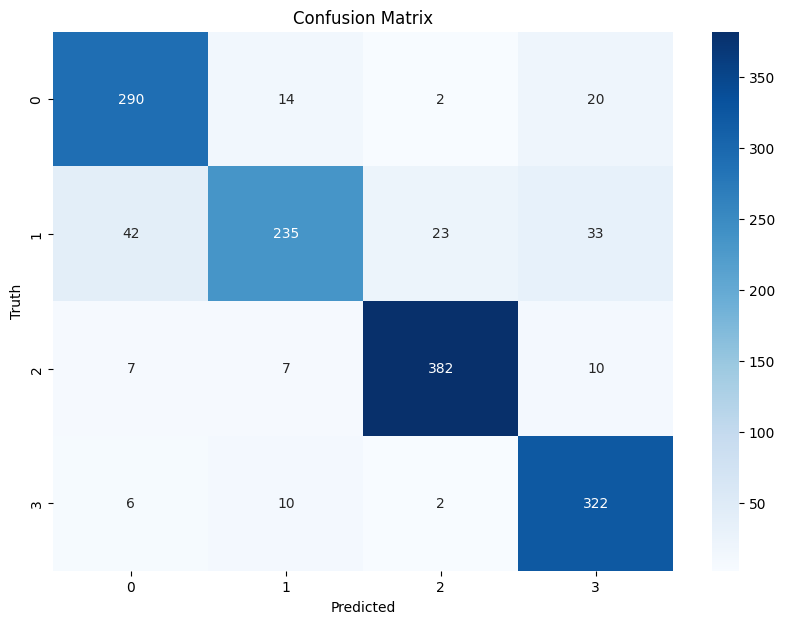

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels, val_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

## Test Results

In [14]:
# Extract features from the test set
test_features = []
test_labels = []
feature_extractor.eval()
with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
        inputs = inputs.to(device)
        features = feature_extractor(inputs)
        test_features.append(features.cpu().numpy())
        test_labels.append(labels.numpy())
test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Make predictions on the test set
test_preds = knn.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 90.03%


## Test Set - Confusion Matrix

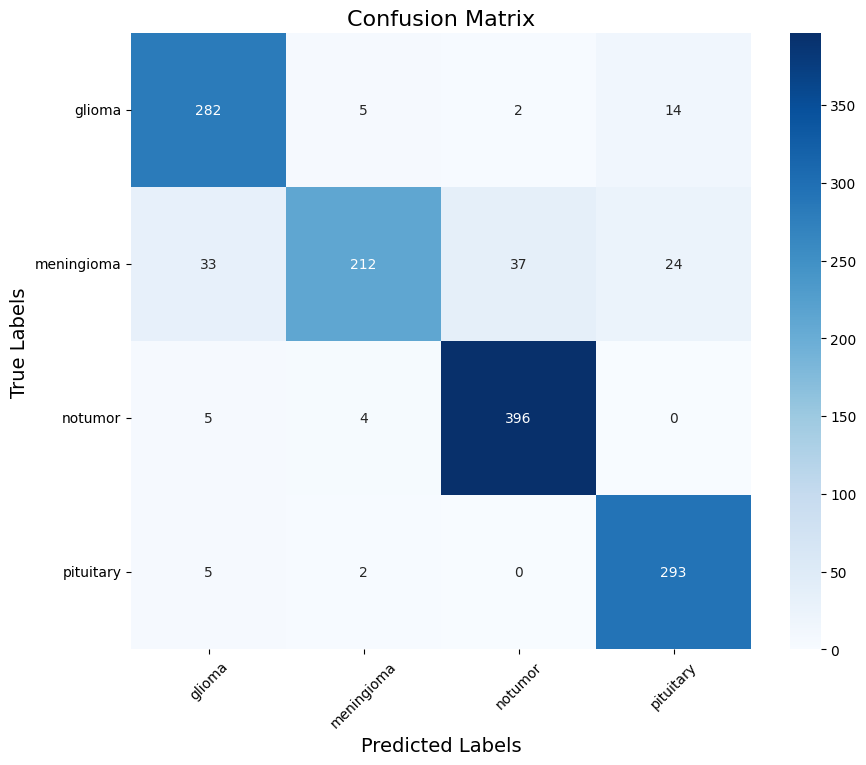

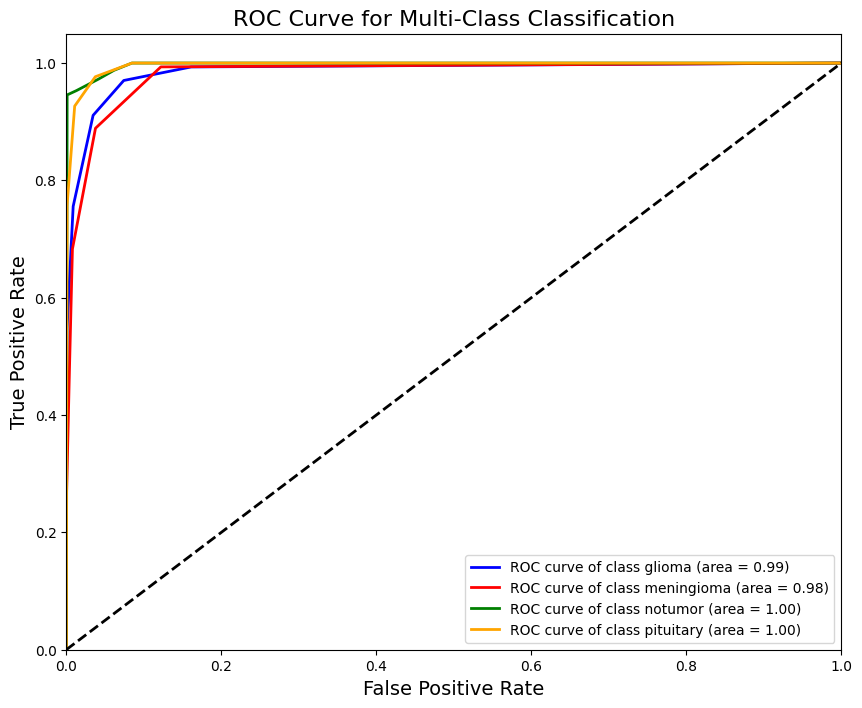

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_test_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], knn.predict_proba(test_features)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {train_dataset.classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower right")
plt.show()

## Evaluation Metrics

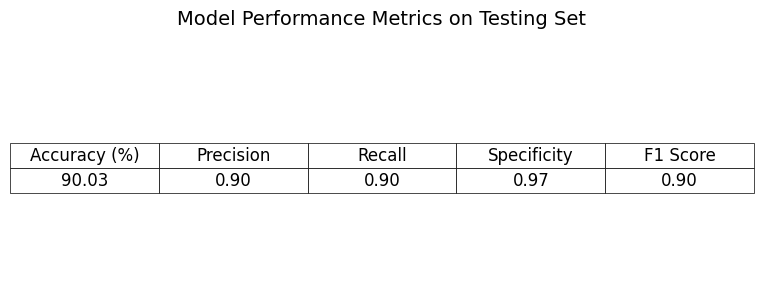

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Compute metrics for the test set
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

# Compute specificity for the test set
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(len(cm)):
        tn = sum(cm[j, k] for j in range(len(cm)) for k in range(len(cm)) if j != i and k != i)
        fp = sum(cm[j, i] for j in range(len(cm)) if j != i)
        specificity.append(tn / (tn + fp))
    return np.mean(specificity)

test_specificity = specificity_score(test_labels, test_preds)

# Data for the table
metrics = ['Accuracy (%)', 'Precision', 'Recall', 'Specificity', 'F1 Score']
values = [f'{test_accuracy * 100:.2f}',  # Format to 2 decimal places
          f'{test_precision:.2f}',
          f'{test_recall:.2f}',
          f'{test_specificity:.2f}',
          f'{test_f1:.2f}']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')

# Create the table
table = ax.table(
    cellText=[values],  # Data for the table
    colLabels=metrics,  # Column headers
    loc='center',       # Position of the table
    cellLoc='center'    # Alignment of text in cells
)

# Style the table to resemble a LaTeX table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Adjust cell size

# Add borders to the table
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    cell.set_edgecolor('black')

# Add a title
plt.title('Model Performance Metrics on Testing Set', fontsize=14, pad=20)

# Show the table
plt.show()